# Dynamic Pricing Model Using Thompson Sampling
We implement a dynamic price optimization model for descrete price levels using Thompson sampling.

### Data
We use an internal simulator. No external datasets are used.

### Papers
1. Ferreira K., Simchi-Levi D., and Wang H. -- Online Network Revenue Management Using Thompson Sampling, November 2017

In [1]:
import numpy as np
from tabulate import tabulate
from scipy.optimize import linprog
import scipy.stats as stats 
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.animation as animation

np.set_printoptions(precision=2)

def tabprint(msg, A):
    print(msg)
    print(tabulate(A, tablefmt="fancy_grid"))
    
plt.rcParams.update({'font.family':'Candara', 'font.serif':['Candara']})
plt.rcParams.update({'pdf.fonttype': 'truetype', 'font.size': 18})

# Step 1: Determine Optimal Prices Using Numerical Optimization

Implement a dynamic pricing model using linear programming to find the optimal price probabilities for a set of fixed price levels, corresponding demand levels, and available product inventory. The goal is to maximize revenue by determining how to allocate the available inventory across different price points. 
- `prices`: A vector representing different price levels. Each element corresponds to a specific price point.<br>
- `demands`: A vector representing the demand at each price level. The i-th element of this vector corresponds to the demand for the product when priced at the i-th price level.<br>
- `inventory`: A scalar representing the number of available units of the product.<br>
- `revenues`: This line calculates the revenue generated at each price point by multiplying the price (`prices`) by the corresponding demand (`demands`). This results in a vector of revenue values.
- `L`: Calculates the number of price levels, which is the length of the `prices` vector.
- `M`: Creates a matrix `M` with dimensions 1xL, filled with ones. This matrix is used in the linear programming problem to represent equality constraints.
- `B`: Creates a 1x1 matrix `B` with a single element 1. This matrix is also used in the linear programming problem to represent equality constraints.
- `Df`: Forms a list containing the `demands` vector. This list is used to represent inequality constraints.

- `linprog`: This function is used for linear programming optimization. It aims to maximize the objective function, which is the negative of the revenue vector, subject to the following constraints:
- Equality constraint: The sum of price probabilities (represented by `price_prob`) should equal 1. This constraint ensures that all available inventory is allocated.
- Inequality constraint: The available inventory should be greater than or equal to the sum of products of price probabilities and demands. This constraint ensures that demand is not overcommitted.
- Bounds: Price probabilities are bounded between 0 and positive infinity.

 - `price_prob`: Extracts the optimal price probabilities from the solution obtained from the linear programming optimization. These probabilities represent the allocation of inventory to each price level.



In [2]:
# Find the optimal distribution of prices (price probabilities) given fixed price levels, 
# corresponding demand levels, and availbale product inventory.
# 
# Inputs:
#   prices, demands, and revenues are vectors (i-th element corresponds to i-th price level)
#   inventory is a scalar (number of availbale units)
def optimal_price_probabilities(prices, demands, inventory):   
    revenues = np.multiply(prices, demands)
    
    L = len(prices)
    M = np.full([1, L], 1)
    B = [[1]]
    Df = [demands]

    res = linprog(-np.array(revenues).flatten(), 
                  A_eq=M, 
                  b_eq=B, 
                  A_ub=Df, 
                  b_ub=np.array([inventory]), 
                  bounds=(0, None))

    price_prob = np.array(res.x).reshape(1, L).flatten()
    return price_prob

In [3]:
# Optimization procedure test
prices = [1.99, 2.49, 2.99, 3.49, 3.99, 4.49]
demands = list(map(lambda p: 50 - 7*p, prices))
revenues = np.multiply(prices, demands)
print(demands)
print(revenues)
print(optimal_price_probabilities(prices, demands, 60))

[36.07, 32.57, 29.07, 25.57, 22.07, 18.57]
[71.78 81.1  86.92 89.24 88.06 83.38]
[8.31e-13 1.66e-12 4.68e-12 1.00e+00 1.16e-11 2.14e-12]


# Step 2: Optimize Prices Dynamically Using Thompson Sampling 

This code appears to implement a dynamic pricing simulation using a Bayesian approach with gamma distributions to model price-dependent demand.

1. **Initial Setup**:
   - `prices`: A list of different price levels.
   - `demand_a` and `demand_b`: Parameters for a linear demand function, where demand is assumed to decrease linearly with increasing price.
   - `θ`: A list of dictionaries, each representing a prior distribution for a price. The prior distribution for each price is assumed to be a gamma distribution with initial shape (`alpha`) and scale (`beta`) parameters set to 30. The `mean` field represents the mean of the gamma distribution, initially set to 30.

2. **Gamma Distribution Function**:
   - `gamma(alpha, beta)`: This function generates a random sample from a gamma distribution with the given shape (`alpha`) and scale (`beta`) parameters.

3. **Sample Demand Function**:
   - `sample_demand(price)`: This function calculates the demand for a product at a given price using a linear demand model (demand_a - demand_b * price) and then generates a random demand value from a Poisson distribution.

4. **Sample Demands from Model Function**:
   - `sample_demands_from_model(θ)`: This function samples demands for each price from the gamma distribution specified by the parameters in the `θ` list.

5. **Simulation Loop**:
   - `T` represents the number of time periods for the simulation.

   Inside the loop:
   - `sample_demands_from_model(θ)` generates demands for each price point based on the gamma distributions defined in the `θ` list.
   - `price_probs` calculates the optimal price probabilities using the `optimal_price_probabilities` function with the sampled demands and an inventory constraint of 60 units.
   - A price is selected at random based on the calculated price probabilities.
   - Demand is sampled for the selected price using the `sample_demand` function.
   - The selected price, demand, and revenue (demand * price) are printed.
   - The current state of the `θ` list (the prior distributions for each price) is copied to `theta_trace`.
   - The history is updated with information about the selected price, demand, revenue, and the state of the `θ` list.
   - The `θ` parameters are updated based on the observed demand. Specifically, the alpha and beta parameters of the gamma distribution are updated, and the mean is recalculated.

This code essentially performs a dynamic pricing simulation where prices are selected based on their probabilities, and the demand is observed and used to update the prior distribution parameters for each price. It's a Bayesian approach to pricing optimization that adapts to observed demand over time while keeping track of the history of price selections, demand, and revenue.


In [4]:
prices = [1.99, 2.49, 2.99, 3.49, 3.99, 4.49]

# Hidden (true) demand parameters - a linear demans function is assumed
demand_a = 50
demand_b = 7

# prior distribution for each price - gamma(α, β)
θ = []
for p in prices:
    θ.append({'price': p, 'alpha': 30.00, 'beta': 1.00, 'mean': 30.00})

def gamma(alpha, beta):
    shape = alpha
    scale = 1/beta
    return np.random.gamma(shape, scale)

def sample_demand(price):
    demand = demand_a - demand_b * price
    return np.random.poisson(demand, 1)[0]

def sample_demands_from_model(θ):
    return list(map(lambda v: gamma(v['alpha'], v['beta']), θ))
        
T = 50
history = []
for t in range(0, T):              # simulation loop
    demands = sample_demands_from_model(θ)
    print(tabulate(np.array(θ), tablefmt="fancy_grid"))
    
    print("demands = ", np.array(demands))
    
    price_probs = optimal_price_probabilities(prices, demands, 60)
    
    # select one best price
    price_index_t = np.random.choice(len(prices), 1, p=price_probs)[0]
    price_t = prices[price_index_t]
    
    # sell at the selected price and observe demand
    demand_t = sample_demand(price_t)
    print('selected price %.2f => demand %.2f, revenue %.2f' % (price_t, demand_t, demand_t*price_t))
    
    theta_trace = []
    for v in θ:
        theta_trace.append(v.copy())
    history.append([price_t, demand_t, demand_t*price_t, theta_trace])
    
    # update model parameters
    v = θ[price_index_t]
    v['alpha'] = v['alpha'] + demand_t
    v['beta'] = v['beta'] + 1
    v['mean'] = v['alpha'] / v['beta']
    
    print("")

╒══════╤════╤═══╤════╕
│ 1.99 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 2.49 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 2.99 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 3.49 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 3.99 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 4.49 │ 30 │ 1 │ 30 │
╘══════╧════╧═══╧════╛
demands =  [29.71 27.19 35.58 28.   24.48 35.04]
selected price 4.49 => demand 27.00, revenue 121.23

╒══════╤════╤═══╤══════╕
│ 1.99 │ 30 │ 1 │ 30   │
├──────┼────┼───┼──────┤
│ 2.49 │ 30 │ 1 │ 30   │
├──────┼────┼───┼──────┤
│ 2.99 │ 30 │ 1 │ 30   │
├──────┼────┼───┼──────┤
│ 3.49 │ 30 │ 1 │ 30   │
├──────┼────┼───┼──────┤
│ 3.99 │ 30 │ 1 │ 30   │
├──────┼────┼───┼──────┤
│ 4.49 │ 57 │ 2 │ 28.5 │
╘══════╧════╧═══╧══════╛
demands =  [41.68 30.38 25.21 20.34 37.07 33.11]
selected price 4.49 => demand 19.00, revenue 85.31

╒══════╤════╤═══╤═════════╕
│ 1.99 │ 30 │ 1 │ 30      │
├──────┼────┼───┼─────────┤
│ 2.49 │ 30 │ 1 │ 30      │
├──────┼────┼───┼─────────┤
│ 2.99 │ 30 │ 1 │ 30      │
├────

findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: F

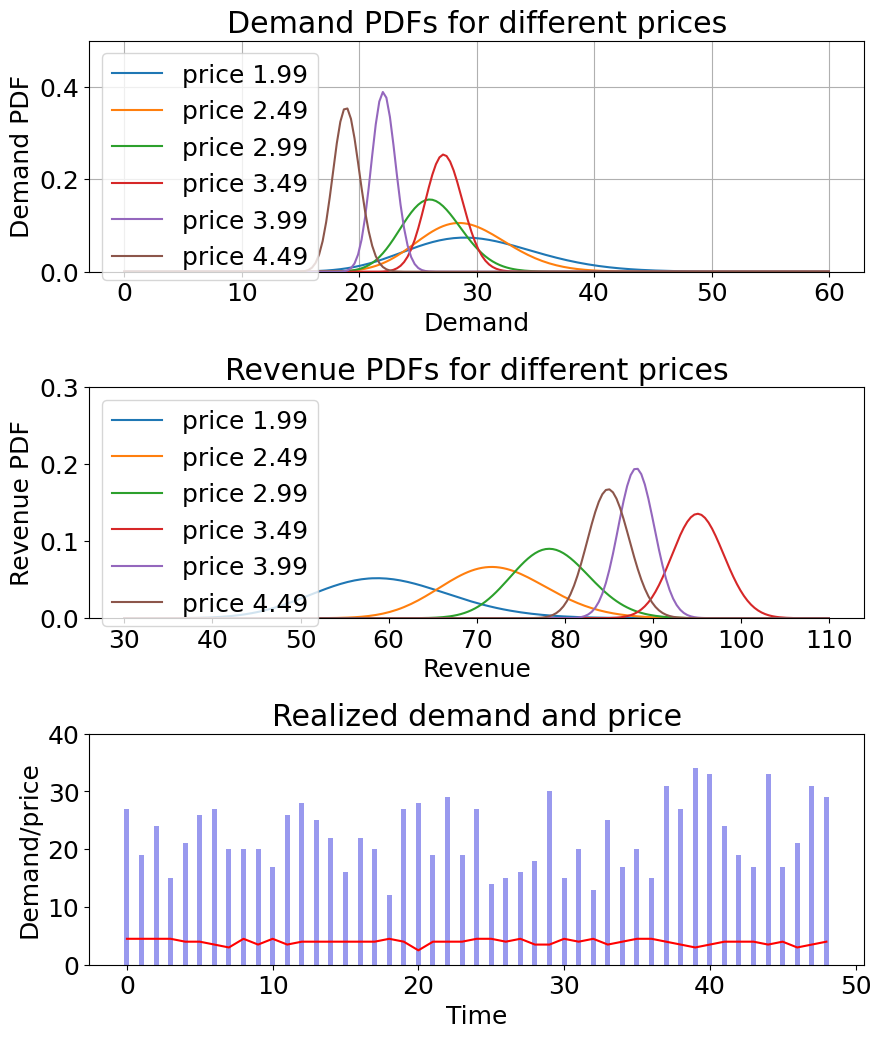

In [5]:
def visualize_snapshot(t):
    plt.subplot(3, 1, 1)
    plt.xlabel('Demand')
    plt.ylabel('Demand PDF')
    plt.title('Demand PDFs for different prices')
    x = np.linspace(0, 60, 200) 
    for i, params in enumerate(history[t][3]):
        y = stats.gamma.pdf(x, a=params['alpha'], scale=1.0/params['beta']) 
        plt.plot(x, y, "-", label='price %.2f' % params['price']) 
    plt.legend(loc='upper left')
    plt.ylim([0, 0.5])
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.xlabel('Revenue')
    plt.ylabel('Revenue PDF')
    plt.title('Revenue PDFs for different prices')
    x = np.linspace(30, 110, 200) 
    for i, params in enumerate(history[t][3]):
        y = stats.gamma.pdf(x, a=params['alpha']*params['price'], scale=1.0/params['beta']) 
        plt.plot(x, y, "-", label='price %.2f' % params['price']) 
    plt.legend(loc='upper left')
    plt.ylim([0, 0.3])
    
    plt.subplot(3, 1, 3)
    plt.xlabel('Time')
    plt.ylabel('Demand/price')
    plt.title('Realized demand and price')
    prices = [h[0] for h in history]
    demands = [h[1] for h in history]
    plt.plot(range(0, t+1), np.array(prices)[0:t+1], 'r-') 
    plt.bar(range(0, T-1), np.pad(np.array(demands)[0:t+1], (0, T-2-t), 'constant'), 0.35, color='#9999ee')
    plt.ylim([0, 40])

fig = plt.figure(figsize = (10, 12))
plt.subplots_adjust(hspace = 0.5)
visualize_snapshot(T - 2)                 # fisualize the final state of the simulation
plt.show()

Demand PDFs for Different Prices: The first subplot displays the PDFs of demand for different prices. Each curve represents the demand distribution for a specific price, and it is modeled as a gamma distribution. The x-axis represents the demand, and the y-axis represents the probability density. This plot provides insights into the variability of demand at different price points.

Revenue PDFs for Different Prices: The second subplot shows the PDFs of revenue for different prices. Similar to the first subplot, each curve represents the revenue distribution for a specific price, and it is modeled as a gamma distribution. The x-axis represents revenue, and the y-axis represents the probability density. This plot helps you understand the variability in revenue generated at different price points.

Realized Demand and Price Over Time: The third subplot displays two pieces of information over time:
It shows the explore and exploilt strategy of the algorithm to learn the relationship between the price and demand using thompson sampling.
The red line represents the prices chosen at each time step (from the beginning of the simulation to the penultimate step).
The bar chart represents the realized demand at each time step. It shows how the demand varies over time. The height of each bar corresponds to the demand, and the x-axis represents time steps.
These visualizations provide insights into how different prices impact demand, revenue, and the evolution of prices and demand over the course of the simulation. The gamma distributions are used to model the uncertainty and variability in demand and revenue for each price point.

MovieWriter imagemagick unavailable; using Pillow instead.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not found.
findfont: Font family 'Candara' not fo

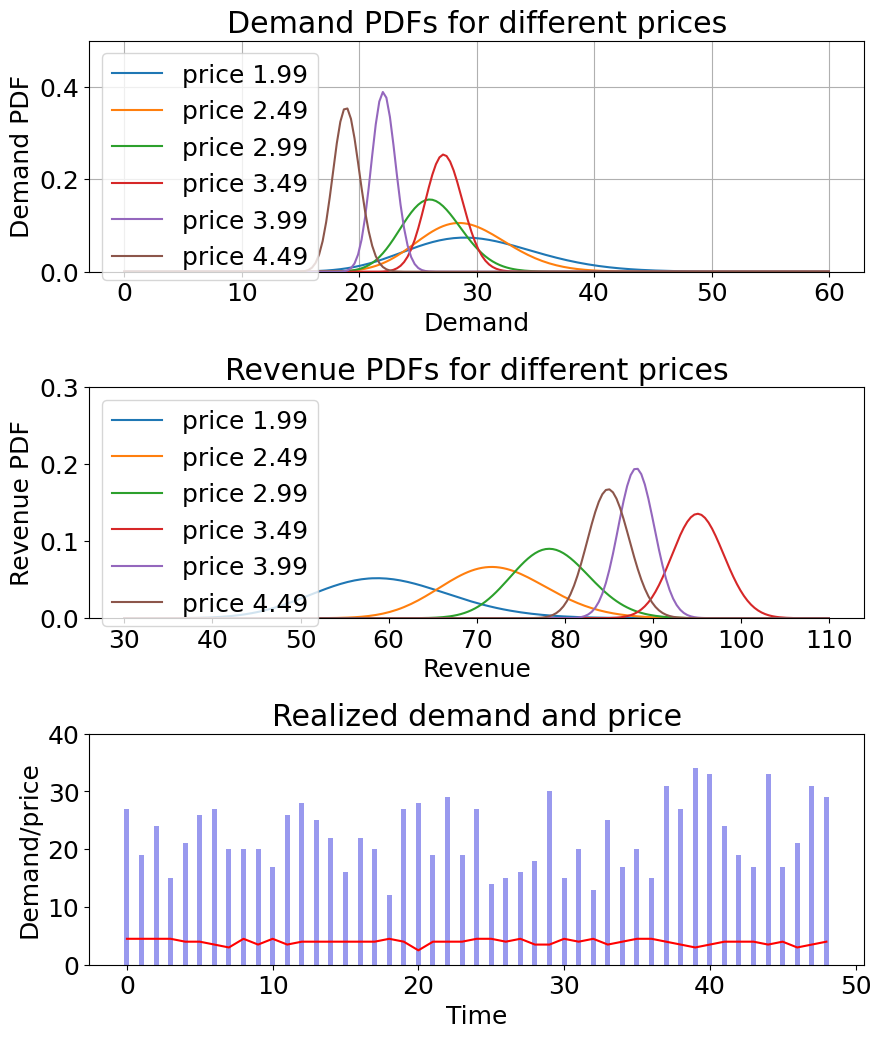

In [6]:
# Render and save the animation of the simulation process

fig = plt.figure(figsize=(10, 12))
plt.subplots_adjust(hspace=0.5)

t = 0
def animate(f):
    global t
    fig.clear()
    visualize_snapshot(t)
    t = t + 1
    
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, bitrate=2800)
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames = T-3, repeat = True)

ani.save('thompson_test_run.gif', writer='imagemagick', fps = 10, dpi = 90)

The animation will start with the initial state of the simulation at t = 0, displaying the demand PDFs, revenue PDFs, and the evolution of prices and realized demand over time.

For each frame, the animate function will increment t by 1, clear the previous frame, and then call visualize_snapshot to visualize the state of the simulation at that time step.

The animation will continue until t reaches T-3, where T is the total number of time steps in your simulation. It means the animation will run up to the penultimate time step of the simulation.

The frames will be displayed at a rate of 10 frames per second (fps), and the animation will loop continuously due to repeat=True.

The saved animation will be in GIF format, named 'thompson_test_run.gif'.

The resulting animation will provide a dynamic visualization of how the simulation evolves over time, allowing you to see how the demand PDFs, revenue PDFs, prices, and demand change as the simulation progresses.